<a href="https://colab.research.google.com/github/Likhithluck/Capstone-Project/blob/likhith/Project_until_march_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the dataset
ds = load_dataset("mychen76/invoices-and-receipts_ocr_v1")

# Check dataset structure
print(ds)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 2043
    })
    test: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 125
    })
    valid: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 70
    })
})


In [2]:
def display(image):
    dpi = 80

    # If the input is a file path, load the image
    if isinstance(image, str):
        im_data = plt.imread(image)
    elif isinstance(image, Image.Image):  # If it's a PIL Image
        im_data = np.array(image)  # Convert PIL Image to NumPy array
    else:
        raise ValueError("Input should be a file path or a PIL Image object.")

    height, width  = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

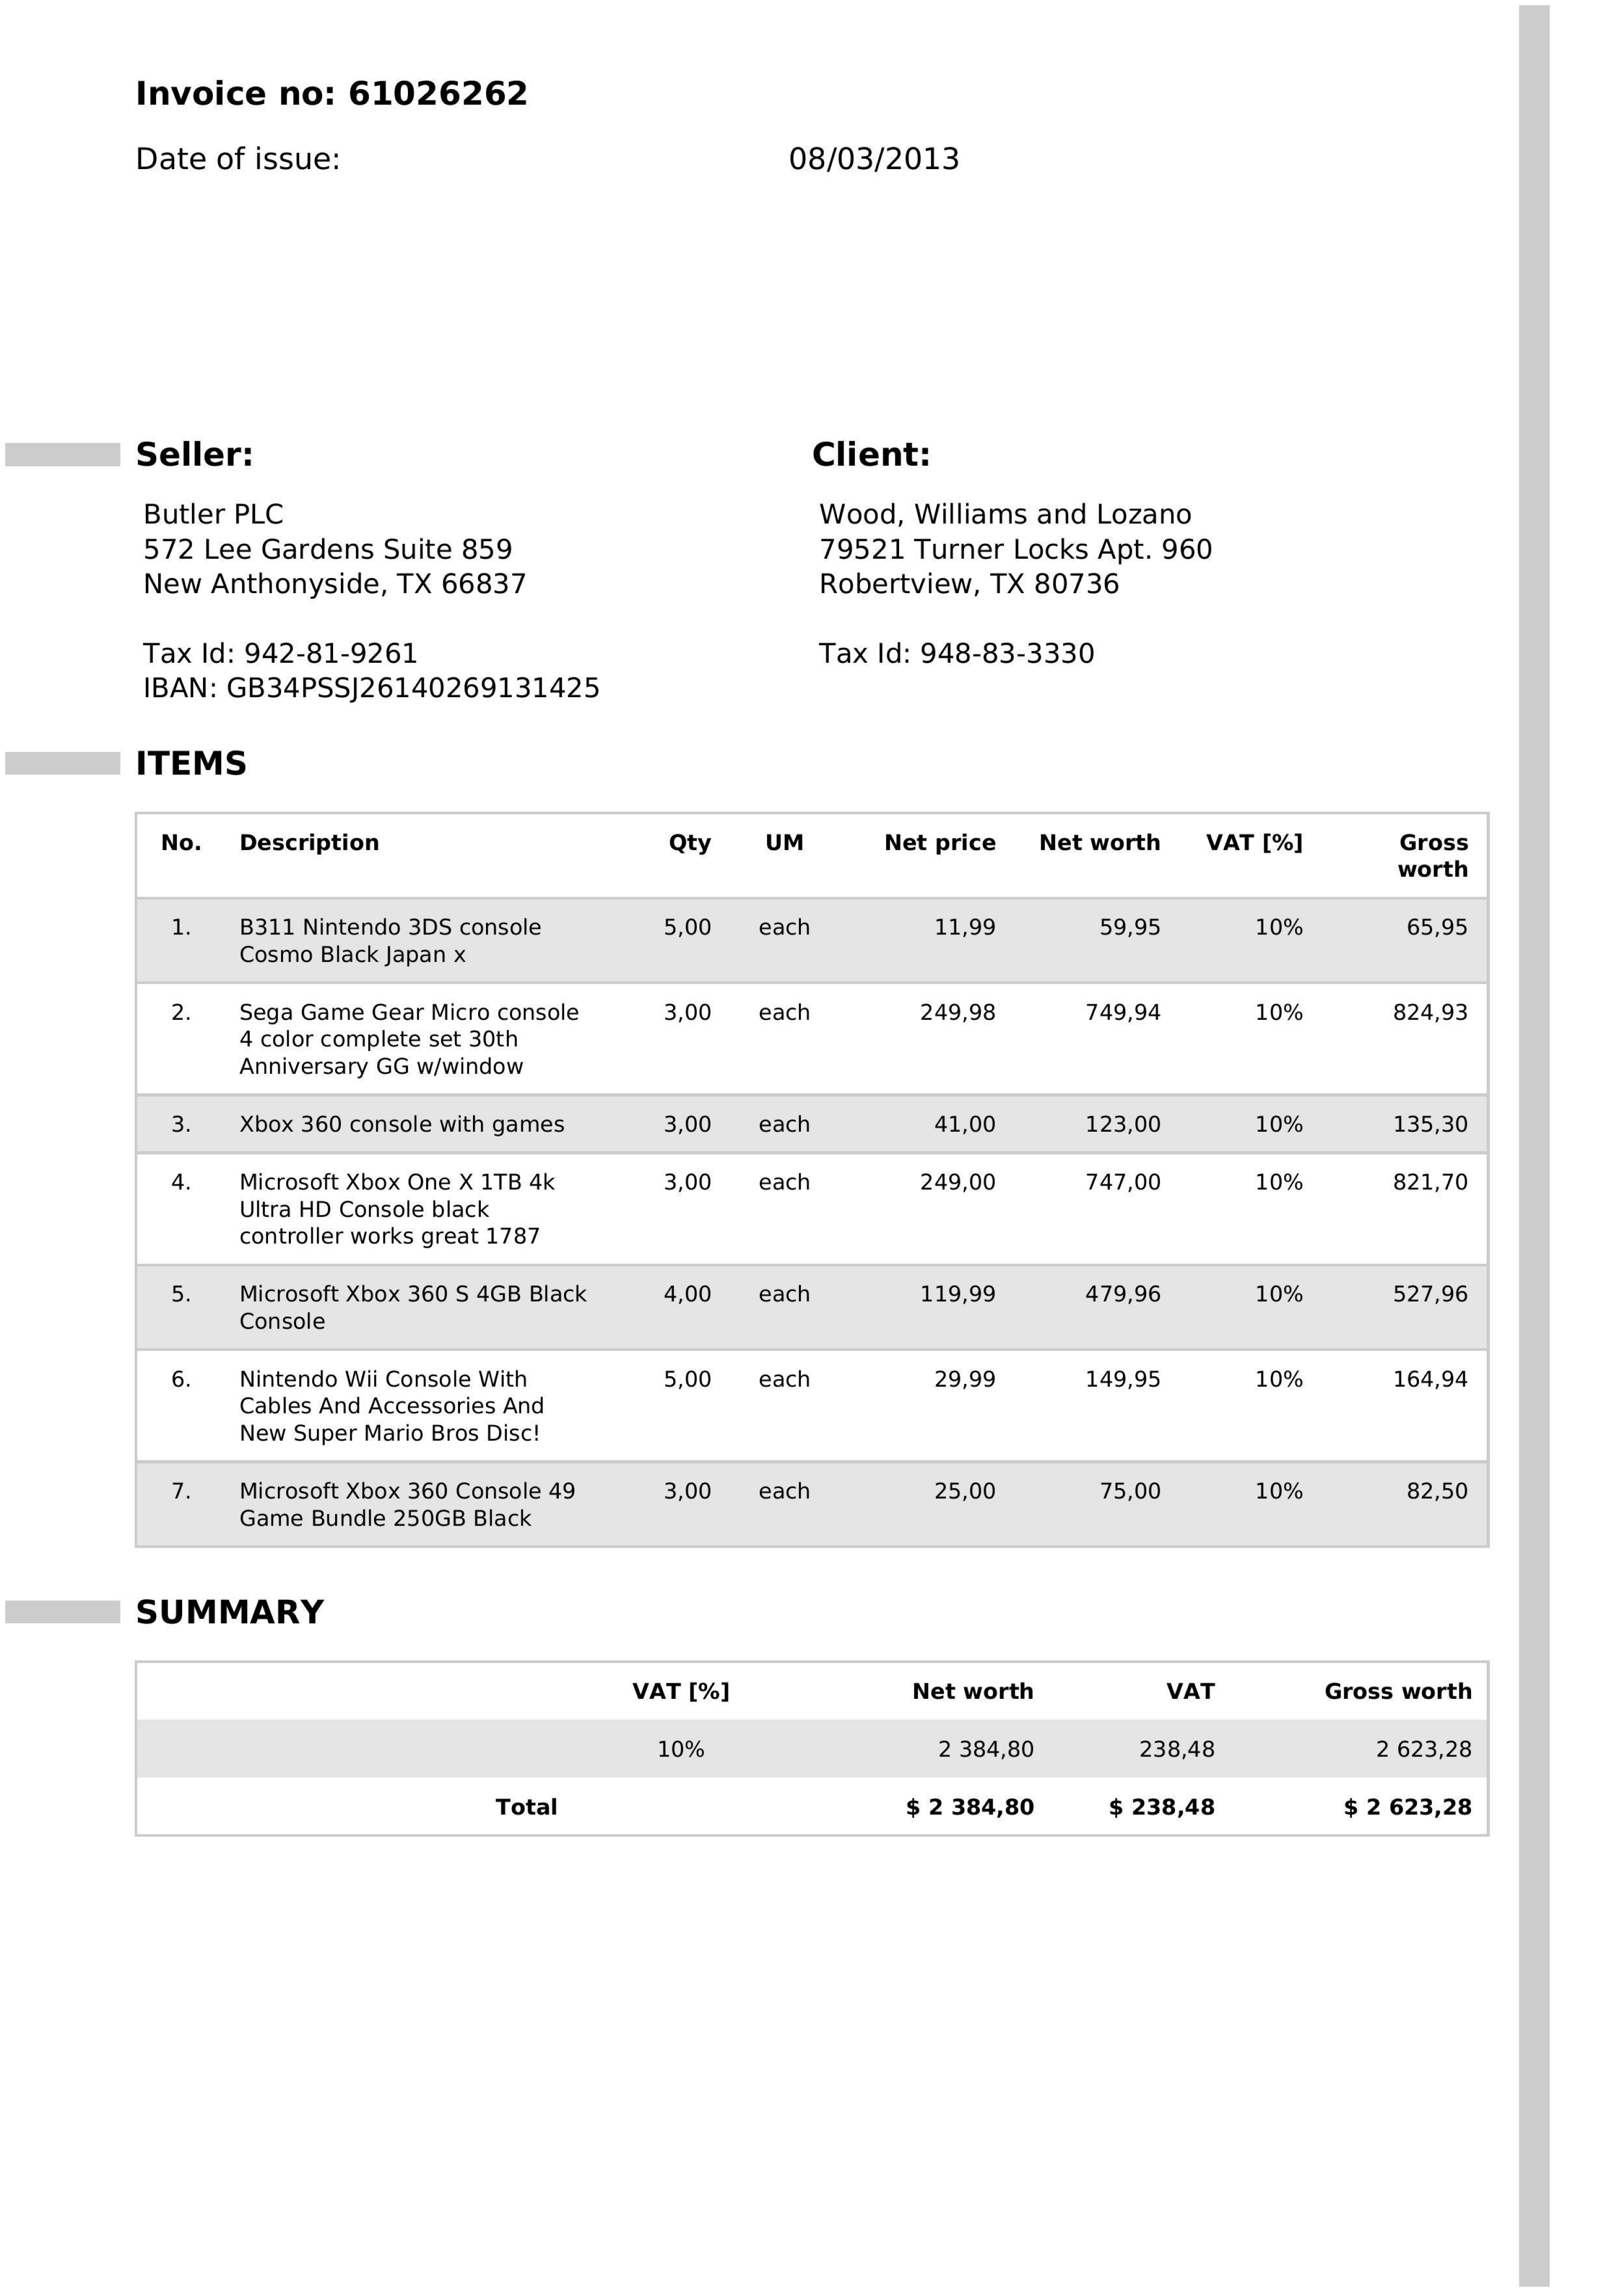

In [81]:
# Get an image from the dataset
sample_image = ds["train"][155]["image"]  # PIL Image object

# Display the image
display(sample_image)

In [82]:
import pytesseract

extracted_text = pytesseract.image_to_string(sample_image)

# Print the extracted text
print(extracted_text)

Invoice no: 61026262

Date of issue:

Seller:

Butler PLC
572 Lee Gardens Suite 859
New Anthonyside, TX 66837

Tax Id: 942-81-9261
IBAN: GB34PSSJ26140269131425

ITEMS
No. Description Qty
1. B311 Nintendo 3DS console 5,00

Cosmo Black Japan x

2. Sega Game Gear Micro console 3,00
4 color complete set 30th
Anniversary GG w/window

3. Xbox 360 console with games 3,00
4. Microsoft Xbox One X 1TB 4k 3,00

Ultra HD Console black
controller works great 1787

5: Microsoft Xbox 360 S 4GB Black 4,00
Console
6. Nintendo Wii Console With 5,00

Cables And Accessories And
New Super Mario Bros Disc!

7. Microsoft Xbox 360 Console 49 3,00
Game Bundle 250GB Black

SUMMARY

VAT [%]
10%

Total

08/03/2013

UM

each

each

each

each

each

each

each

Client:

Wood, Williams and Lozano

79521 Turner Locks Apt. 960
Robertview, TX 80736

Tax Id: 948-83-3330

Net price

11,99

249,98

41,00

249,00

119,99

29,99

25,00

Net worth
2 384,80

$ 2 384,80

Net worth VAT [%]
59,95 10%
749,94 10%
123,00 10%
747,0

In [83]:
#function to extract Invoice no

import re

# Function to extract the invoice number
def extract_invoice_number(text):
    # Search for a line that starts with "Invoice no:"
    match = re.search(r"Invoice no:\s*(\d+)", text)
    if match:
        return match.group(1)  # Return the invoice number
    return None  # Return None if no invoice number is found

In [84]:
invoice_number = extract_invoice_number(extracted_text)
print("Invoice Number:", invoice_number)

Invoice Number: 61026262


In [85]:
#function for extracting date

import re
from datetime import datetime

def extract_date(ocr_text):
    # Define possible date patterns
    date_patterns = [
        r'\b(\d{1,2}/\d{1,2}/\d{4})\b',  # Matches MM/DD/YYYY or DD/MM/YYYY
        r'\b(\d{4}-\d{1,2}-\d{1,2})\b'   # Matches YYYY-MM-DD
    ]

    # Try matching different patterns
    for pattern in date_patterns:
        match = re.search(pattern, ocr_text)
        if match:
            raw_date = match.group(1)  # Extracted date string

            # Convert date to standard format (YYYY-MM-DD)
            for fmt in ("%m/%d/%Y", "%d/%m/%Y", "%Y-%m-%d"):
                try:
                    formatted_date = datetime.strptime(raw_date, fmt).strftime("%Y-%m-%d")
                    return formatted_date
                except ValueError:
                    continue

    return None  # Return None if no date is found

In [86]:
extracted_date = extract_date(extracted_text)
print("Date of issue:", extracted_date)

Date of issue: 2013-08-03


In [87]:
#function for extracting seller and client details

import json

def extract_details(text):
    lines = text.split("\n")

    seller_name, seller_address, seller_tax, seller_iban = "", "", "", ""
    client_name, client_address, client_tax = "", "", ""

    seller_section, client_section = False, False
    seller_lines, client_lines = [], []

    for line in lines:
        line = line.strip()

        if line.startswith("Seller:"):
            seller_section = True
            client_section = False
            continue
        elif line.startswith("Client:"):
            seller_section = False
            client_section = True
            continue

        if seller_section:
            seller_lines.append(line)
        elif client_section:
            client_lines.append(line)

    # Extract Seller Details
    if seller_lines:
        # Skip the first empty line after "Seller:"
        seller_name = seller_lines[0] if seller_lines[1] == "" else seller_lines[1]
        seller_address = " ".join(seller_lines[2:4])  # Join address lines
        for line in seller_lines:
            if "Tax Id:" in line:
                seller_tax = line.split(":")[1].strip()
            if "IBAN:" in line:
                seller_iban = line.split(":")[1].strip()

    # Extract Client Details
    if client_lines:
        # Skip the first empty line after "Client:"
        client_name = client_lines[0] if client_lines[1] == "" else client_lines[1]
        client_address = " ".join(client_lines[2:4])  # Join address lines
        for line in client_lines:
            if "Tax Id:" in line:
                client_tax = line.split(":")[1].strip()

    extracted_details = {
        "Seller": {
            "Name": seller_name,
            "Address": seller_address,
            "Tax ID": seller_tax,
            "IBAN": seller_iban
        },
        "Client": {
            "Name": client_name,
            "Address": client_address,
            "Tax ID": client_tax
        }
    }

    return extracted_details


In [88]:
structured_data = extract_details(extracted_text)
print(json.dumps(structured_data, indent=4))

{
    "Seller": {
        "Name": "Butler PLC",
        "Address": "572 Lee Gardens Suite 859 New Anthonyside, TX 66837",
        "Tax ID": "942-81-9261",
        "IBAN": "GB34PSSJ26140269131425"
    },
    "Client": {
        "Name": "Wood, Williams and Lozano",
        "Address": " 79521 Turner Locks Apt. 960",
        "Tax ID": "948-83-3330"
    }
}


In [89]:
import re
from datetime import datetime
import json

class InvoiceParser:

    def __init__(self, text):
        self.text = text

    # Function to extract Invoice number
    def extract_invoice_number(self):
        match = re.search(r"Invoice no:\s*(\d+)", self.text)
        if match:
            return match.group(1)
        return None

    # Function to extract Date of issue
    def extract_date(self):
        # Define possible date patterns
        date_patterns = [
            # Matches MM/DD/YYYY or DD/MM/YYYY
            r'\b(\d{1,2}/\d{1,2}/\d{4})\b',
            # Matches YYYY-MM-DD
            r'\b(\d{4}-\d{1,2}-\d{1,2})\b'
        ]

        # Try matching different patterns
        for pattern in date_patterns:
            match = re.search(pattern, self.text)
            if match:
                raw_date = match.group(1)

                # Convert date to standard format (YYYY-MM-DD)
                for fmt in ("%m/%d/%Y", "%d/%m/%Y", "%Y-%m-%d"):
                    try:
                        formatted_date = datetime.strptime(raw_date, fmt).strftime("%Y-%m-%d")
                        return formatted_date
                    except ValueError:
                        continue

        return None

    # Function to extract Seller and Client details
    def extract_details(self):
        lines = self.text.split("\n")

        seller_name, seller_address, seller_tax, seller_iban = "", "", "", ""
        client_name, client_address, client_tax = "", "", ""

        seller_section, client_section = False, False
        seller_lines, client_lines = [], []

        for line in lines:
            line = line.strip()

            if line.startswith("Seller:"):
                seller_section = True
                client_section = False
                continue
            elif line.startswith("Client:"):
                seller_section = False
                client_section = True
                continue

            if seller_section:
                seller_lines.append(line)
            elif client_section:
                client_lines.append(line)

        # Extract Seller Details
        if seller_lines:
            # Skip the first empty line after "Seller:"
            seller_name = seller_lines[0] if seller_lines[1] == "" else seller_lines[1]
            seller_address = " ".join(seller_lines[2:4])
            for line in seller_lines:
                if "Tax Id:" in line:
                    seller_tax = line.split(":")[1].strip()
                if "IBAN:" in line:
                    seller_iban = line.split(":")[1].strip()

        # Extract Client Details
        if client_lines:
            # Skip the first empty line after "Client:"
            client_name = client_lines[0] if client_lines[1] == "" else client_lines[1]
            client_address = " ".join(client_lines[2:4])
            for line in client_lines:
                if "Tax Id:" in line:
                    client_tax = line.split(":")[1].strip()

        extracted_details = {
            "Seller": {
                "Name": seller_name,
                "Address": seller_address,
                "Tax ID": seller_tax,
                "IBAN": seller_iban
            },
            "Client": {
                "Name": client_name,
                "Address": client_address,
                "Tax ID": client_tax
            }
        }

        return extracted_details

    def extract_all_info(self):
        return {
            "Invoice Number": self.extract_invoice_number(),
            "Date of Issue": self.extract_date(),
            "Seller and Client Details": self.extract_details()
        }


# Create an InvoiceParser instance
invoice_parser = InvoiceParser(extracted_text)

# Extract all details and print the structured data as JSON
structured_data = invoice_parser.extract_all_info()
print(json.dumps(structured_data, indent=4))


{
    "Invoice Number": "61026262",
    "Date of Issue": "2013-08-03",
    "Seller and Client Details": {
        "Seller": {
            "Name": "Butler PLC",
            "Address": "572 Lee Gardens Suite 859 New Anthonyside, TX 66837",
            "Tax ID": "942-81-9261",
            "IBAN": "GB34PSSJ26140269131425"
        },
        "Client": {
            "Name": "Wood, Williams and Lozano",
            "Address": " 79521 Turner Locks Apt. 960",
            "Tax ID": "948-83-3330"
        }
    }
}
